In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline 

In [2]:
from scipy import stats

Результат двух тестов:

5_task_1:

    id – id клиента в эксперименте
    group – в каком разрешении показывались картинки (A – прямоугольные 16:9, B – квадратные, C – прямоугольные 12:4)
    events – сколько блюд суммарно было заказано за период

5_task_2:

    id – id клиента в эксперименте
    segment – сегмент (high/low)
    group – вид кнопки (control – старая версия, test – новая версия)
    events – сколько блюд суммарно было заказано за период

In [3]:
task_1 = pd.read_csv('5_task_1.csv')
task_2 = pd.read_csv('5_task_2.csv')

In [4]:
task_1

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38
...,...,...,...
29995,22932,C,38
29996,21787,C,25
29997,5054,C,34
29998,10254,C,27


In [5]:
task_2

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0
...,...,...,...,...
99995,60695,control,low,15.0
99996,5934,control,low,16.0
99997,30046,control,low,22.0
99998,26474,control,low,21.0


In [6]:
a = task_1.query('group == "A"').events
b = task_1.query('group == "B"').events
c = task_1.query('group == "C"').events

Проверим, являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена.

In [7]:
#через scipy
stats.levene(a, b, c)

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

    Нулевая гипотеза теста Левена:  дисперсии гомогенны. 
    Альтернативная гипотеза:  дисперсии гетерогенны (различаются).
 - p-value > 0.05, **не можем отклонить нулевую гипотезу**

Убедимся, что данные распределены нормально, применив тест Шапиро-Уилка. Перед применением критерия при проверке на нормальность обязательно сделайте семплирование (1000 наблюдений), так как на больших выборках могут получаться неверные результаты.

In [8]:
sample_a = task_1.query('group == "A"').events.sample(1000, random_state=17)
sample_b = task_1.query('group == "B"').events.sample(1000, random_state=17)
sample_c = task_1.query('group == "C"').events.sample(1000, random_state=17)

In [9]:
stats.shapiro(sample_a)

ShapiroResult(statistic=0.9973153471946716, pvalue=0.09609563648700714)

In [10]:
stats.shapiro(sample_b)

ShapiroResult(statistic=0.9980818629264832, pvalue=0.3186272084712982)

In [11]:
stats.shapiro(sample_c)

ShapiroResult(statistic=0.9981189966201782, pvalue=0.3360903561115265)

Распределение  везде нормально т.к. р > 0.05

In [12]:
# pip install statsmodels --upgrade

In [13]:
# from scipy.signal._signaltools import centered
import statsmodels.api as sm

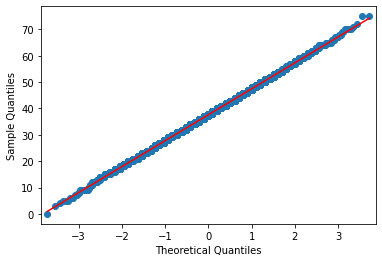

In [14]:
fig = sm.qqplot(b, line="r")
plt.show()

Проверим, какой формат фотографий блюд является наилучшим, т.е. в какой из групп в среднем покупали больше всего.

- дисперсии внутри групп примерно одинаковы (гомогенны)
- данные распределены нормально

посчитаем однофакторный ANOVA:

In [15]:
stats.f_oneway(a,b,c)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

Различия значимы (но какие именно?)

Теперь используем **критерий Тьюки** и определим, между какими группами есть статистически значимые различия.    Фактически рассчитывается по той же формуле, что и t-критерий, но несколько иначе рассчитывается стандартная ошибка – в результате критерий Тьюки более консервативен, чем обычный t-критерий, но гораздо менее консервативен по сравнению с поправкой Бонферрони.

Нулевая гипотеза:  статистическая неразличимость средних.

In [16]:
from statsmodels.stats.multicomp import (pairwise_tukeyhsd,
                                         MultiComparison)

In [17]:
# попарные сравнения (с Тьюки)
# В качестве первого аргумента мы даём массив с зависимой переменной events , 
# в качестве аргумента groups - массив с независимой переменной.
pairwise_tukeyhsd(task_1.events, task_1.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.0,7.7038,8.3642,True
A,C,-2.1093,0.0,-2.4395,-1.7791,True
B,C,-10.1433,0.0,-10.4735,-9.8131,True


reject = True - различия значимые.

Столбец **meandiff** отражает различие в средних между **второй и первой группой, именно в таком порядке.**

т.е. в группе В самые большие средние продажи

<AxesSubplot:xlabel='group', ylabel='events'>

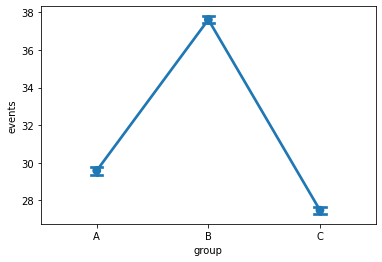

In [18]:
sns.pointplot(x="group", y="events", data=task_1, capsize=.1)

<AxesSubplot:xlabel='group', ylabel='events'>

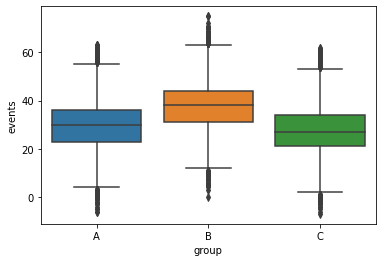

In [19]:
sns.boxplot(x="group", y="events", data=task_1)

#### Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

In [20]:
# многофакторный дисперсионный анализ

In [21]:
task_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [22]:
# визуализируйте распределение events для контрольной и тестовой групп

test = task_2.query('group == "test"').events
control = task_2.query('group == "control"').events

In [23]:
test

0        78.0
1        71.0
2        80.0
3        80.0
4        78.0
         ... 
59995    35.0
59996    31.0
59997    32.0
59998    18.0
59999    31.0
Name: events, Length: 50000, dtype: float64

C:\Users\maksa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\maksa\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


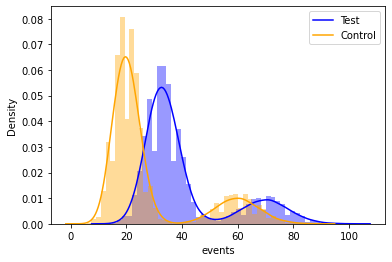

In [24]:
sns.distplot(test, color='blue')
sns.distplot(control, color='orange')
plt.legend(['Test', 'Control'])

Посчитайте среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя. 

In [25]:
task_2.groupby(['group', 'segment']).events.describe()

count       mean       std   min   25%   50%   75%    max
group   segment                                                             
control high     10000.0  59.970800  7.805347  31.0  55.0  60.0  65.0   89.0
        low      40000.0  20.031575  4.473576   4.0  17.0  20.0  23.0   41.0
test    high     10000.0  69.938500  8.403974  40.0  64.0  70.0  76.0  102.0
        low      40000.0  33.025925  5.720845  13.0  29.0  33.0  37.0   59.0

In [26]:
task_2.groupby(['group', 'segment']).events.describe().T.round(2)   #  T - транспонирует набор данных

group     control                test          
segment      high       low      high       low
count    10000.00  40000.00  10000.00  40000.00
mean        59.97     20.03     69.94     33.03
std          7.81      4.47      8.40      5.72
min         31.00      4.00     40.00     13.00
25%         55.00     17.00     64.00     29.00
50%         60.00     20.00     70.00     33.00
75%         65.00     23.00     76.00     37.00
max         89.00     41.00    102.00     59.00

Мы хотим проверить эффект нескольких переменных – group и segment – на events, с взаимодействием факторов. 

    Многофакторный дисперсионный анализ:  
    Аnova_lm   -  "events ~ segment * group"  или  "events ~ segment + group + segment:group"

In [27]:
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm

In [28]:
model = smf.ols(formula = "events ~ segment * group", data = task_2).fit()
anova_lm(model, typ = 2)

,sum_sq,df,F,PR(>F)
segment,2.362480e+07,1.0,689756.377485,0.000000e+00
group,3.837195e+06,1.0,112031.864120,0.000000e+00
segment:group,3.664244e+04,1.0,1069.823273,2.060261e-233
Residual,3.424956e+06,99996.0,NaN,NaN


Все значимы. PR(>F) <  0.05

Используем критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия.

В данном случае для последующих сравнений между группами можно проделать следующую операцию: соединить колонки group и segment в combination, чтобы потом передать в аргумент groups в MultiComparison либо pairwise_tukey

In [29]:
task_2['combi'] = task_2['group'] + ' \ ' + task_2['segment']

In [30]:
task_2

,id,group,segment,events,combi
0,83440,test,high,78.0,test \ high
1,96723,test,high,71.0,test \ high
2,68719,test,high,80.0,test \ high
3,50399,test,high,80.0,test \ high
4,95613,test,high,78.0,test \ high
...,...,...,...,...,...
99995,60695,control,low,15.0,control \ low
99996,5934,control,low,16.0,control \ low
99997,30046,control,low,22.0,control \ low
99998,26474,control,low,21.0,control \ low


In [31]:
# Попарные сравнения (с Тьюки)
# Нулевая гипотеза: статистическая неразличимость средних.
# В качестве первого аргумента мы даём массив с зависимой переменной events , 
# в качестве аргумента groups - массив с независимой переменной.
pairwise_tukeyhsd(task_2.events, task_2.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control,test,12.389,0.0,12.185,12.593,True


In [32]:
pairwise_tukeyhsd(task_2.events, task_2.segment).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
high,low,-38.4259,0.0,-38.5583,-38.2935,True


In [33]:
pairwise_tukeyhsd(task_2.events, task_2.combi).summary() #  task_2.events - переменная событий, task_2.combi - комбинация групп

group1,group2,meandiff,p-adj,lower,upper,reject
control \ high,control \ low,-39.9392,0.0,-40.1073,-39.7711,True
control \ high,test \ high,9.9677,0.0,9.7551,10.1803,True
control \ high,test \ low,-26.9449,0.0,-27.113,-26.7768,True
control \ low,test \ high,49.9069,0.0,49.7388,50.075,True
control \ low,test \ low,12.9944,0.0,12.888,13.1007,True
test \ high,test \ low,-36.9126,0.0,-37.0807,-36.7445,True


Вывод:

    Разница между значением у тестовой группы сегмента low и контрольной группой этого же сегмента равна примерно 13
    Разница между control/high и test/high составила около 10
    Для обоих сегментов показатели статистически значимо _увеличились_ по сравнению с контрольной группой

<AxesSubplot:xlabel='group', ylabel='events'>

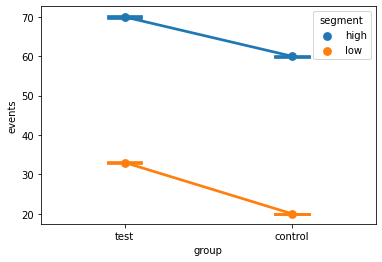

In [34]:
sns.pointplot(x="group", y="events", hue="segment", data=task_2, capsize=0.2)

<AxesSubplot:xlabel='group', ylabel='events'>

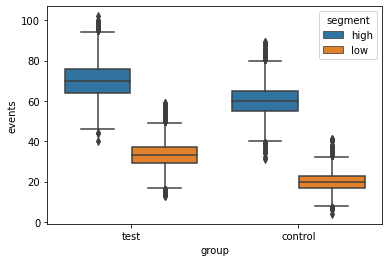

In [35]:
sns.boxplot(x="group", y="events", hue="segment", data=task_2)

Фактор group оказался 
значимым
, фактор segment – 
значимым
, их взаимодействие – 
значимо
. Судя по графику, для всех групп среднее значение events 
увеличилось
, поэтому решение: 
используем новую версию
.

### Корреляция

In [36]:
from scipy import stats

In [37]:
x = [4,5,2,3,1]
y = [2,1,4,3,5]

Коэффициента корреляции Пирсона.

требований здесь два: линейность взаимосвязи и нормальность распределений данных (особенно отсутствие выбросов)

In [38]:
stats.pearsonr(x,y)

PearsonRResult(statistic=-1.0, pvalue=0.0)

C:\Users\maksa\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:>

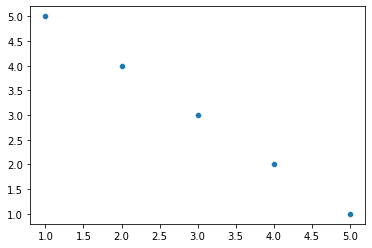

In [39]:
sns.scatterplot(x,y)